# Image Denoising using Autoencoders + Predictions using the Autoencoder

In [37]:
import numpy as np
import tensorflow as tf

### Data Loading

In [38]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
print('Number of train samples: {}, Number of test samples: {}'.format(X_train.shape, X_test.shape))

Number of train samples: (60000, 28, 28), Number of test samples: (10000, 28, 28)


### Normalizing the data values between 0 & 1

In [39]:
X_train = X_train / 255.
X_test = X_test / 255.

In [40]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### Inducing Noise in the data

In [41]:
factor = 0.5
X_train_noisy = X_train + factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0.0, 1.0)
X_test_noisy = np.clip(X_test_noisy, 0.0, 1.0)

In [42]:
import matplotlib.pyplot as plt

### Visualizing Noise induced data

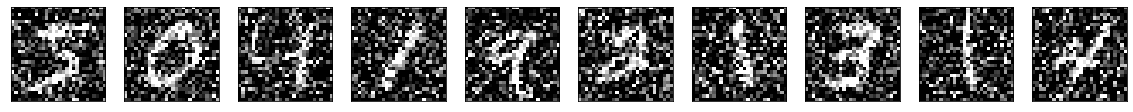

In [43]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_train_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Training a Convolution Autoencoder

In [47]:
inputs = tf.keras.layers.Input(shape=(28, 28, 1))

## Encoder
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='input')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same', name='encoder')(x)

## Decoder
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
decoder = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

model = tf.keras.models.Model(inputs, decoder)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
input (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 64)        0   

In [49]:
model.fit(X_train_noisy, X_train, 
          epochs=20, batch_size=256, 
          validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 24s 405us/sample - loss: 0.1333 - accuracy: 0.8076 - val_loss: 0.1179 - val_accuracy: 0.8097
Epoch 2/20
60000/60000 [==============================] - 44s 730us/sample - loss: 0.1155 - accuracy: 0.8108 - val_loss: 0.1113 - val_accuracy: 0.8113
Epoch 3/20
60000/60000 [==============================] - 33s 543us/sample - loss: 0.1099 - accuracy: 0.8117 - val_loss: 0.1065 - val_accuracy: 0.8109
Epoch 4/20
60000/60000 [==============================] - 26s 438us/sample - loss: 0.1068 - accuracy: 0.8121 - val_loss: 0.1051 - val_accuracy: 0.8121
Epoch 5/20
60000/60000 [==============================] - 27s 443us/sample - loss: 0.1048 - accuracy: 0.8124 - val_loss: 0.1027 - val_accuracy: 0.8116
Epoch 6/20
60000/60000 [==============================] - 26s 439us/sample - loss: 0.1032 - accuracy: 0.8126 - val_loss: 0.1015 - val_accuracy: 0.8121
Epoch 7/20
60000/60000 [====================

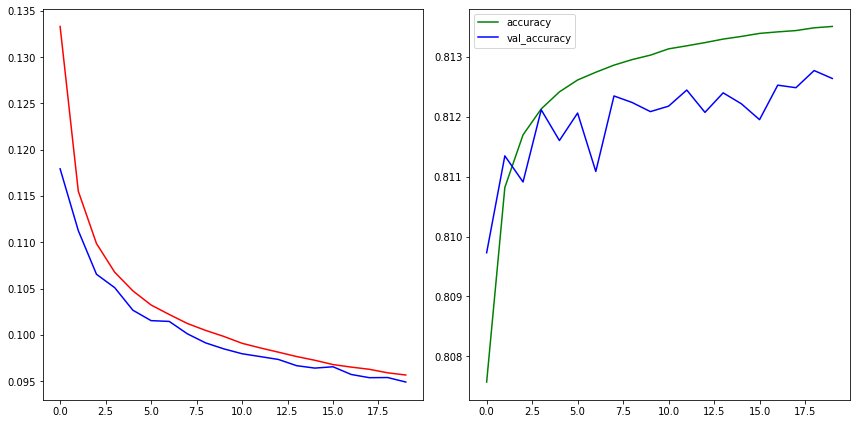

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='loss', c='r')
plt.plot(model.history.history['val_loss'], label='loss', c='b')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='accuracy', c='g')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy', c='b')

plt.legend()
plt.tight_layout()

### Creating an Encoder using the previously trained Autoencoder

In [51]:
encoder = tf.keras.models.Model(inputs, encoder)
encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
input (Conv2D)               (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 7, 7, 64)          0         
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


### Predictions on the Noisy (Test) images + visualization

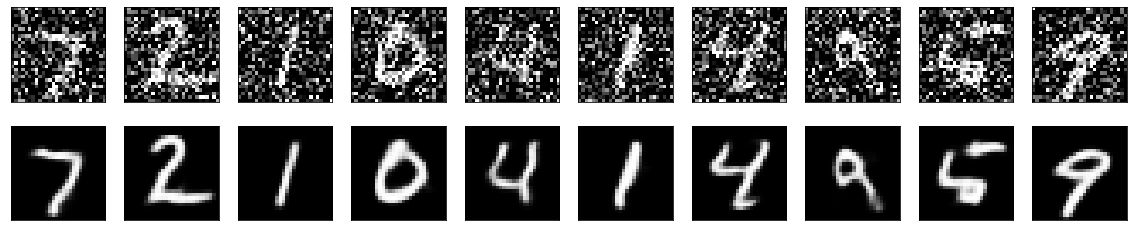

In [52]:
decoded_images = model.predict(X_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Setting the layers of the pre-trained encoder to not re-train

In [53]:
## Setting encoder layers to not retrain
for layer in encoder.layers:
    layer.trainable = False
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000001D798B49BC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D798B49B88> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001D798B7E048> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000001D798B7EA88> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000001D798B63148> False


### Classification model using the pre-trained Encoder + FC layers

In [54]:
## Classification model with the pre-trained Autoencoder head
model = tf.keras.models.Sequential()
model.add(encoder)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 7, 7, 64)          18816     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                100384    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 119,530
Trainable params: 100,714
Non-trainable params: 18,816
_________________________________________________________________


In [55]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print('Shape of y_train: {}, shape of y_test: {}'.format(y_train.shape, y_test.shape))

Shape of y_train: (60000, 10), shape of y_test: (10000, 10)


In [56]:
model.fit(X_train, y_train, 
          epochs=20, 
          batch_size=128, 
          validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 127us/sample - loss: 0.2831 - accuracy: 0.9263 - val_loss: 0.1066 - val_accuracy: 0.9714
Epoch 2/20
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0944 - accuracy: 0.9732 - val_loss: 0.0804 - val_accuracy: 0.9758
Epoch 3/20
60000/60000 [==============================] - 9s 144us/sample - loss: 0.0734 - accuracy: 0.9784 - val_loss: 0.0596 - val_accuracy: 0.9804
Epoch 4/20
60000/60000 [==============================] - 9s 148us/sample - loss: 0.0608 - accuracy: 0.9814 - val_loss: 0.0549 - val_accuracy: 0.9828
Epoch 5/20
60000/60000 [==============================] - 8s 133us/sample - loss: 0.0531 - accuracy: 0.9836 - val_loss: 0.0503 - val_accuracy: 0.9831
Epoch 6/20
60000/60000 [==============================] - 7s 112us/sample - loss: 0.0475 - accuracy: 0.9853 - val_loss: 0.0524 - val_accuracy: 0.9824
Epoch 7/20
60000/60000 [==========================

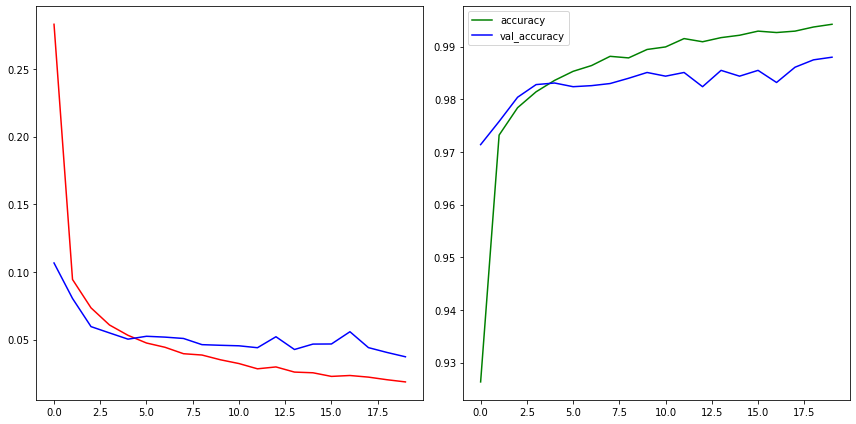

In [61]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='loss', c='r')
plt.plot(model.history.history['val_loss'], label='loss', c='b')

plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='accuracy', c='g')
plt.plot(model.history.history['val_accuracy'], label='val_accuracy', c='b')

plt.legend()
plt.tight_layout()

In [62]:
preds = model.predict(X_test_noisy)

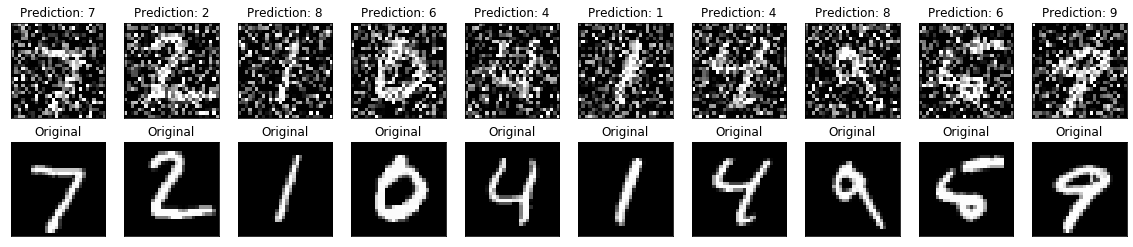

In [65]:
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
    
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Prediction: {}'.format(str(np.argmax(preds[i]))))

    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('Original')
plt.show()